## Загрузим нужные библиотеки

In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

### Reproducibility block

In [4]:
# seed the RNG for all devices (both CPU and CUDA)
#torch.manual_seed(1984)

#Disabling the benchmarking feature causes cuDNN to deterministically select an algorithm, 
#possibly at the cost of reduced performance.
#torch.backends.cudnn.benchmark = False

# for custom operators,
import random
random.seed(5986721)

# 
np.random.seed(62185)

#sklearn take seed from a line abowe

Выполним загрузу датсета

In [8]:
DIR_DATA  = os.path.join(os.getcwd(), 'data')
#DIR_TRAIN = os.path.join(DIR_DATA, 'train')
#DIR_TEST  = os.path.join(DIR_DATA, 'test')
DIR_SUBM  = os.path.join(os.getcwd(), 'subm')

In [11]:
df_train = pd.read_csv(os.path.join(DIR_DATA, 'train.csv'), index_col= 0)
df_test = pd.read_csv(os.path.join(DIR_DATA, 'test.csv'), index_col= 0)

## Проанализируем датасет

In [12]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7000 entries, 624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ to 627f1c089a794743b070ff73hVvdVmFxS2SlZ2_lECDEow
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   title               7000 non-null   object 
 1   publish_date        7000 non-null   object 
 2   session             7000 non-null   object 
 3   authors             7000 non-null   object 
 4   ctr                 7000 non-null   float64
 5   category            7000 non-null   object 
 6   tags                7000 non-null   object 
 7   views               7000 non-null   int64  
 8   depth               7000 non-null   float64
 9   full_reads_percent  7000 non-null   float64
dtypes: float64(3), int64(1), object(6)
memory usage: 601.6+ KB


Заменим категорию и автора на число

In [13]:
df_train["category"] = df_train["category"].astype('category')
df_train["category"] = df_train["category"].cat.codes
df_train["category"] = df_train["category"].astype('int')

In [14]:
df_train["authors"] = df_train["authors"].astype('category')
df_train["authors"] = df_train["authors"].cat.codes
df_train["authors"] = df_train["authors"].astype('int')

In [15]:
df_train['day'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%d").astype(int)
df_train['mounth'] = pd.to_datetime(df_train['publish_date']).dt.strftime("%m").astype(int)

In [17]:
df_train.head(3)

,title,publish_date,session,authors,ctr,category,tags,views,depth,full_reads_percent,day,mounth
document_id,,,,,,,,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,Европейский банк развития приостановил доступ ...,2022-04-04 10:29:44,IDE7mtH4RBqGn-8MXfGffQ,560,1.580,2,"['55928d339a794751dc8303d6', '542d1e28cbb20f86...",20460,1.134,35.850,4,4
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,Кремль назвал регулярным процессом учебные зап...,2022-02-18 10:00:39,KtVJsteHStO5oditt3Uvzw,38,1.853,0,"['549d25df9a794775979561d2', '58abcf539a7947f1...",19038,1.142,38.355,18,2
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,Госсекретарь Швеции заявила о нежелании вступа...,2022-02-12 04:24:02,hk7puWJwSziw0m3sfTkKWA,560,0.000,0,"['5430f451cbb20f73931ecd05', '5409f15de063daa0...",51151,1.185,36.424,12,2


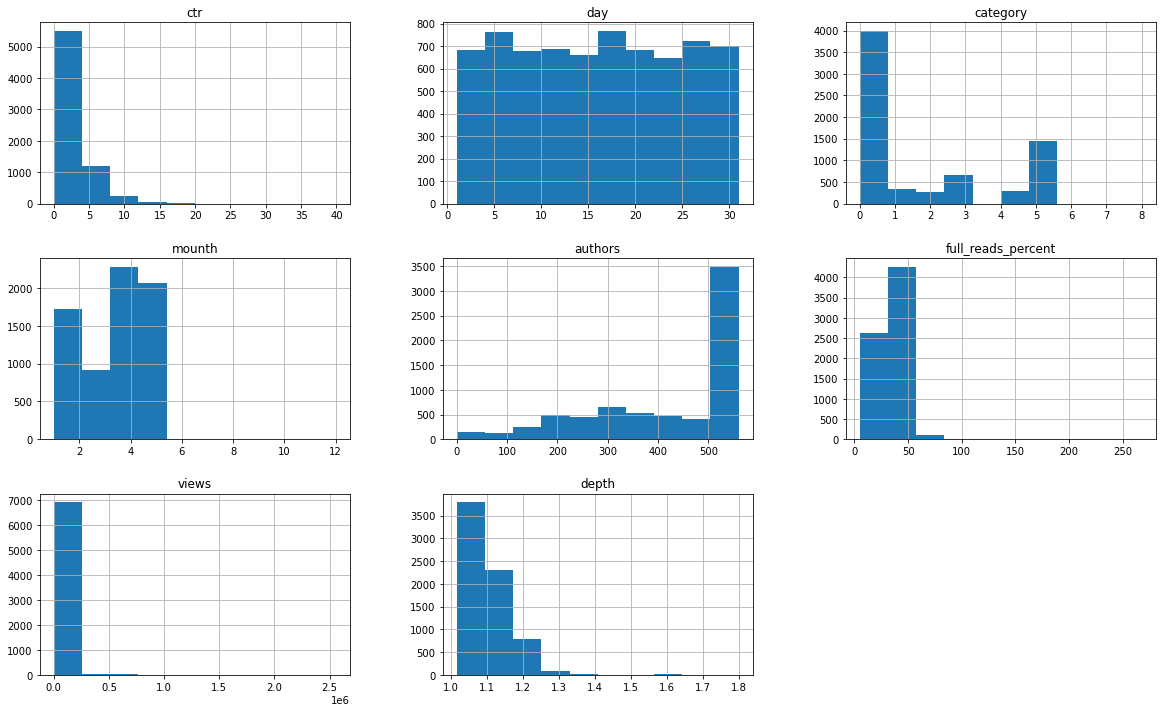

In [18]:
features = list(set(df_train.columns) - set(['publish_date']))

_ = df_train[features].hist(figsize=(20,12))

Всего 9 категорий статей

In [19]:
df_train.category.value_counts()

0    3988
5    1456
3     667
1     338
4     283
2     265
7       1
6       1
8       1
Name: category, dtype: int64

## Выделим выборки

In [20]:
X = df_train.drop(["views","depth","full_reads_percent","title","publish_date", "session", "tags"], axis = 1)
y = df_train[["views","depth","full_reads_percent"]]

In [21]:
X.head()

,authors,ctr,category,day,mounth
document_id,,,,,
624ac09c9a7947db3d80c98eIDE7mtH4RBqGn-8MXfGffQ,560,1.580,2,4,4
620f6b899a7947701cf489e1KtVJsteHStO5oditt3Uvzw,38,1.853,0,18,2
620730cf9a7947ab96a44e27hk7puWJwSziw0m3sfTkKWA,560,0.000,0,12,2
6262a5889a79470b78c9ca307UKY2SSZTjCcjhwBzxw37w,560,0.000,0,22,4
626678929a79477ca0101568wuMYES90REuV5YhrN75IXg,560,0.000,5,25,4


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Подбор модели

In [23]:
regr = RandomForestRegressor(random_state=0)

Обучим модель

In [24]:
regr.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

Предскажем значения

In [25]:
pred = regr.predict(X_test)

## Оценка точности

In [26]:
score_views = r2_score(y_test["views"], pred[:,0])
score_depth = r2_score(y_test["depth"], pred[:,1])
score_frp = r2_score(y_test["full_reads_percent"], pred[:,2])

In [27]:
score = 0.4 * score_views + 0.3 * score_depth + 0.3 * score_frp

score

0.5497252178188364

Предсказание для теста

In [29]:
df_test["category"] = df_test["category"].astype('category')
df_test["category"] = df_test["category"].cat.codes
df_test["category"] = df_test["category"].astype('int')

In [30]:
df_test["authors"] = df_test["authors"].astype('category')
df_test["authors"] = df_test["authors"].cat.codes
df_test["authors"] = df_test["authors"].astype('int')

In [31]:
df_test['day']    = pd.to_datetime(df_test['publish_date']).dt.strftime("%d").astype(int)
df_test['mounth'] = pd.to_datetime(df_test['publish_date']).dt.strftime("%m").astype(int)

In [36]:
X_pred = df_test.drop(["title","publish_date", "session", "tags"], axis = 1)

In [40]:
X_pred.head(3)

,authors,ctr,category,day,mounth
document_id,,,,,
61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,325,0.000,0,1,2
628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,325,1.598,0,24,5
627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,325,2.006,0,12,5


In [41]:
pred = regr.predict(X_pred)

submission

In [45]:
subm = pd.read_csv(os.path.join(DIR_SUBM, 'sample_solution.csv'))
subm.shape

(3000, 4)

In [46]:
subm.head()

,document_id,views,depth,full_reads_percent
0,61f9569a9a794794245a82abJ0AvX96vTAaQCiWVbzoMdw,1,1,1
1,628c22b89a79470e553f594bQS5CqzXYRnmDdR2LaSreEw,1,1,1
2,627cb3249a7947ebdd752865XVsoyrUOT8OJJg2_finJhw,1,1,1
3,628618629a7947d4927eb812upfii3whSSuMXCqcqF8VbQ,1,1,1
4,620e76109a7947235623695b5hzCiIHdSYKQIr8WAM18bw,1,1,1


In [53]:
subm.document_id = df_test.index
subm.views = pred[:,0]
subm.depth = pred[:,1]
subm.full_reads_percent = pred[:,2]


#y_test["views"], pred[:,0]
#y_test["depth"], pred[:,1]
#y_test["full_reads_percent"], pred[:,2]

In [54]:
subm.to_csv(os.path.join(DIR_SUBM, '0_baseline.csv'), index = False)